Using layer: conv_pw_13
conv1
conv_pw_1
conv_pw_2
conv_pw_3
conv_pw_4
conv_pw_5
conv_pw_6
conv_pw_7
conv_pw_8
conv_pw_9
conv_pw_10
conv_pw_11
conv_pw_12
conv_pw_13


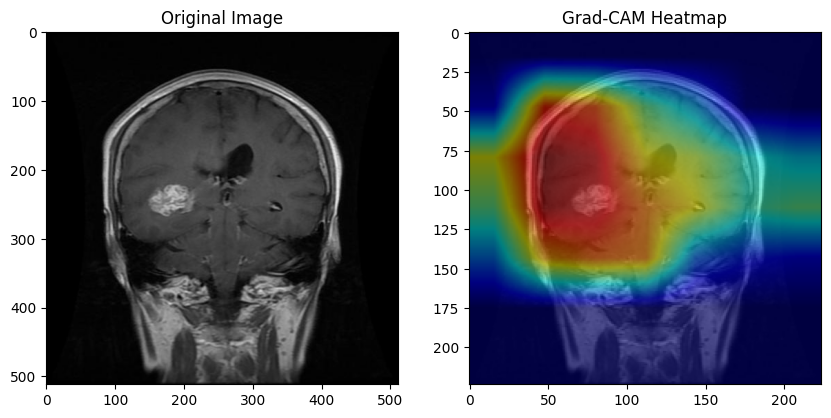

In [41]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load trained model
model = load_model("../models/tumornotumor.keras")

# Load and preprocess image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))
    img = img_to_array(img) / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)
    return img


def generate_gradcam(img_array, model, layer_name="conv_pw_13", pred_index=None):
    # Get last convolutional layer dynamically
    last_conv_layer = model.layers[0].get_layer(layer_name)  # ✅ Corrected


    # Define the Grad-CAM model
    grad_model = tf.keras.models.Model(
        inputs=model.layers[0].input, 
        outputs=[last_conv_layer.output, model.layers[0].output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])  # Get the predicted class index
            loss = tf.gather(predictions, pred_index, axis=1)  # ✅ Fix tensor indexing


    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(conv_outputs * pooled_grads, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # Apply ReLU
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap


# Overlay heatmap on image
def overlay_heatmap(img_path, heatmap, alpha=0.5):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return overlay

layer_name = "conv_pw_13"  # ✅ The last Conv2D layer
print(f"Using layer: {layer_name}")  # Debugging

img_array = preprocess_image("test_image.jpg")
heatmap = generate_gradcam(img_array, model, layer_name)

for layer in model.layers[0].layers:  # MobileNet is inside model.layers[0]
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name)

img_path = "test_image.jpg"

# heatmap = generate_gradcam(img_array, model, last_conv_layer)
overlay = overlay_heatmap(img_path, heatmap)

# Show results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.title("Grad-CAM Heatmap")

plt.show()
